In [17]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

Neural Network Model for Hyper Parameter Tuning

In [18]:
def branin(X, Y):
    return -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)


In [19]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [20]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, a, b: 0.1*(a - 4) * x + 0.05*(b + 3) * x**2 + r.normal(0, sim_stdev)

In [21]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 5, 10)
Y = np.random.uniform(-5, 5, 10)

# Calculate the outputs using Branin and Currin functions
output1 = branin(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [22]:
sim_eval = lambda x, y, a, b: branin(x, y) + sim_err(x, a, b)

In [23]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (2,5)},
          {'name': 'b', 'type': 'continuous', 'domain': (-4,-1)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 3.8852474  -3.02137993]


In [24]:
df_sim = df.copy()

df_sim

,x,y,z,a,b,sim_z,diff
0,-0.829780,-0.808055,-175.141124,3.885247,-3.02138,-175.130338,-0.010787
1,2.203245,1.852195,-20.326731,3.885247,-3.02138,-20.305764,-0.020968
2,-4.998856,-2.955478,-132.403402,3.885247,-3.02138,-132.356385,-0.047016
3,-1.976674,3.781174,-39.397506,3.885247,-3.02138,-39.250183,-0.147322
4,-3.532441,-4.726124,-149.789289,3.885247,-3.02138,-149.851263,0.061974
5,-4.076614,1.704675,-120.336105,3.885247,-3.02138,-120.365432,0.029327
6,-3.137398,-0.826952,-93.320859,3.885247,-3.02138,-93.276838,-0.044021
7,-1.544393,0.586898,-131.648403,3.885247,-3.02138,-131.663437,0.015033
8,-1.032325,-3.596131,-207.066951,3.885247,-3.02138,-207.059704,-0.007247
9,0.388167,-3.018985,-198.619945,3.885247,-3.02138,-198.580098,-0.039848


In [25]:
df

,x,y,z,a,b,sim_z,diff
0,-0.829780,-0.808055,-175.141124,3.885247,-3.02138,-175.130338,-0.010787
1,2.203245,1.852195,-20.326731,3.885247,-3.02138,-20.305764,-0.020968
2,-4.998856,-2.955478,-132.403402,3.885247,-3.02138,-132.356385,-0.047016
3,-1.976674,3.781174,-39.397506,3.885247,-3.02138,-39.250183,-0.147322
4,-3.532441,-4.726124,-149.789289,3.885247,-3.02138,-149.851263,0.061974
5,-4.076614,1.704675,-120.336105,3.885247,-3.02138,-120.365432,0.029327
6,-3.137398,-0.826952,-93.320859,3.885247,-3.02138,-93.276838,-0.044021
7,-1.544393,0.586898,-131.648403,3.885247,-3.02138,-131.663437,0.015033
8,-1.032325,-3.596131,-207.066951,3.885247,-3.02138,-207.059704,-0.007247
9,0.388167,-3.018985,-198.619945,3.885247,-3.02138,-198.580098,-0.039848


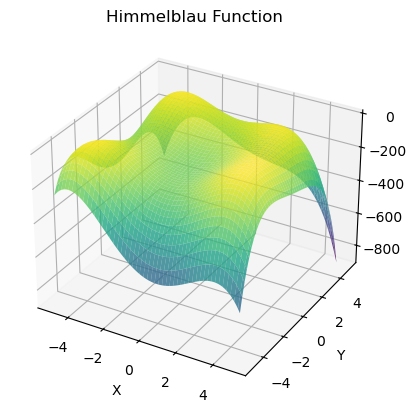

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = branin(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Himmelblau Function')

# Show the plot
plt.show()

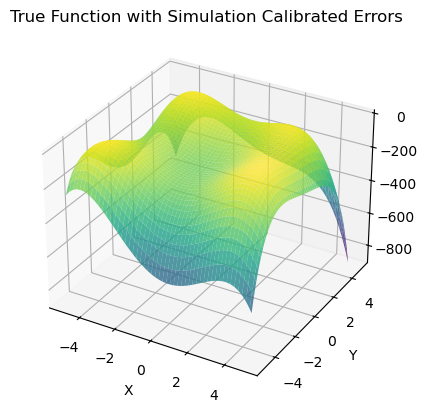

In [27]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [28]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [29]:
def perform_iteration(df):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3, shuffle=True, random_state=0)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['sim_z']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    pred_mean, pred_std = mc_dropout_predictions(best_model, X_scaled)

    x1_range = np.linspace(-5, 5, 100)
    x2_range = np.linspace(-5, 5, 100)

    # Define probability function based on model uncertainty
    def p(x):
        x_reshaped = x.reshape(1, -1)
        mean, std = mc_dropout_predictions(best_model, x_reshaped)
        mean = mean.ravel() 
        std = std.ravel() 
         # Check if x stays within x1_range and x2_range
        if x_reshaped[0, 0] >= np.min(x1_range) and x_reshaped[0, 0] <= np.max(x1_range) and \
        x_reshaped[0, 1] >= np.min(x2_range) and x_reshaped[0, 1] <= np.max(x2_range):
            # Compute the upper bound of the 95% confidence interval and compare with the median
            return np.max([mean[0] + 1.96 * std[0] - df['sim_z'].median(), 0])
        else:
            return 0  # Return 0 if the point is outside the valid input space

    # Metropolis step proposal distribution N(0,sig**2)
    def metropolis_step(x, sig):
        prop_x = x + np.random.normal(0, sig, size=x.shape)
        u = np.random.uniform(0, 1)
        if u < np.min([1.0, p(prop_x) / p(x)]):
            return prop_x
        else:
            return x

    # Metropolis-Hastings Sampler
    def mh_sampler(sig, sample_size, burn_in, lag):
        x = np.array([[df["x"].loc[np.argmax(df["sim_z"])], df["y"].loc[np.argmax(df["sim_z"])]]])
        for i in range(burn_in):
            x = metropolis_step(x, sig)
        samples = x
        for i in range(sample_size - 1):
            for j in range(lag):
                x = metropolis_step(x, sig)
            samples = np.vstack((samples, x))
        return samples

    # Generate new points using MH sampler
    sig = 0.5  # Standard deviation for MH proposal distribution
    sample_size = 10
    burn_in = 100
    lag = 10
    new_points = mh_sampler(sig, sample_size, burn_in, lag)

    # Convert new points to dataframe
    new_points_df = pd.DataFrame(new_points, columns=['x', 'y'])

    # Add simulated responses for new points
    new_points_df['z'] = branin(new_points_df['x'], new_points_df['y']) + ran_err(sample_size, 0.05)
    new_points_df["a"] = bo.x_opt[0]
    new_points_df["b"] = bo.x_opt[1]
    new_points_df["sim_z"] = sim_eval(new_points_df['x'], new_points_df['y'], result.x[0], result.x[1])
    new_points_df["diff"] = new_points_df["z"] - new_points_df["sim_z"]

    # Add new points to original dataframe
    df = pd.concat([df, new_points_df], axis=0, ignore_index=True)

    # Produce Meshgrid of results with C.I.
    x1_range = np.linspace(-5, 5, 100)
    x2_range = np.linspace(-5, 5, 100)

    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

    x_grid_scaled = scaler_x.transform(x_grid)

    # Perform MC Dropout predictions for entire meshgrid
    pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid_scaled)

    # Reshape predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x1_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

    # Plotting the predictions with confidence intervals and next sampling points
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the mean prediction surface
    ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    # Plot the upper and lower confidence intervals
    ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Getting mean of new points for visualization
    new_x = new_points_df[['x', 'y']].to_numpy()
    new_x = scaler_x.transform(new_x)
    new_mean, new_std = mc_dropout_predictions(best_model, new_x)


    ax.scatter(new_points_df[:, 0], new_points_df[:, 1], new_mean, color='black', marker='o', label='Next Sampling Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    ax.legend(loc='upper left')

    print(new_points_df)

    # Show the plot
    plt.show()
    return df, new_points_df


In [30]:
def perform_round(df, df2):
    for _ in range(8): 
        df, new_points_df = perform_iteration(df) 

    # Add new points to original dataframe
    df2 = pd.concat([df2, new_points_df], axis=0, ignore_index=True)

    # Drops last 4 columnc for recalculation 
    df2 = df2.iloc[:, :-4]

    df2

    # Update the Simulation Model with updated physical tests
    bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
    bo.run_optimization(max_iter=max_bo_iter)
    df2["a"] = bo.x_opt[0]
    df2["b"] = bo.x_opt[1]
    print(bo.x_opt)
    sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

    # Create the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors')

        # Show the plot
    plt.show()

    df = df2

    return df, df2

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.1
dropout_rate: 0.5
batch_size: 20
epochs: 178
Epoch 1/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step - loss: 19539.5312
Epoch 2/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13873.8379
Epoch 3/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5390.9429
Epoch 4/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 14466.2168
Epoch 5/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2705.1460
Epoch 6/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5456.2158
Epoch 7/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7186.8447
Epoch 8/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7217.1279
Epoch 9/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4462.8330
Epoch 10/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3460.0593
Epoch 11/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5789.5771
Epoch 12/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4203.0342
Epoch 13/178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 301

InvalidIndexError: (slice(None, None, None), 0)

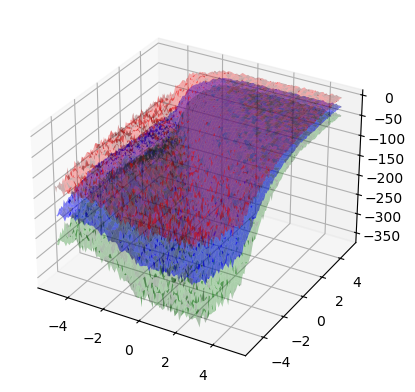

In [32]:
df_sim, df = perform_round(df_sim, df)

Best hyperparameters:
num_layers: 10
num_units: 200
learning_rate: 0.0003516414236625464
dropout_rate: 0.28646870972783367
batch_size: 20
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 11397.8174
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 11396.4746
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11393.1416
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11392.9229
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11390.3896
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 11388.7822
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11384.2021
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 11383.3311
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11375.4521
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11375.8848
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11372.9961
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11358.8398
Epoch 13/200
1/1 ━━━━

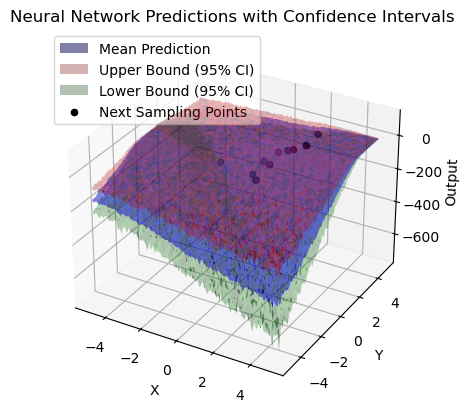

In [21]:
df = perform_iteration(df)

In [ ]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 4
num_units: 138
learning_rate: 0.002164573506112058
dropout_rate: 0.5
batch_size: 20
epochs: 150
Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10932.0977
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9734.6631 
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10300.4150 
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9557.9287 
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10144.4600 
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9898.0244 
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10699.3145 
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8833.0508 
Epoch 9/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9705.4287  
Epoch 10/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9350.5361 
Epoch 11/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8843.4648 
Epoch 12/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8366.4502 
Epoch 13/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.028104074321300857
dropout_rate: 0.24281654117069268
batch_size: 20
epochs: 200
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13408.3984  
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8730.5078 
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5843.6743 
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5936.3550 
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4042.5532 
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3561.2139 
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2796.9473 
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2671.5085 
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2289.3413 
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2252.3291 
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2097.1670 
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2008.3484 
Epoch 13/200
3/3 ━━━━━━━━━━━━━━

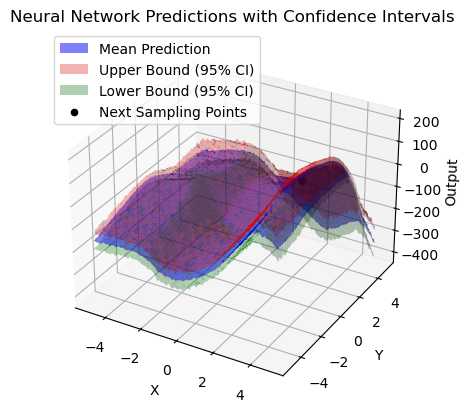

In [58]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 2
num_units: 200
learning_rate: 0.04684378814509843
dropout_rate: 0.5
batch_size: 119
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step - loss: 13342.6230
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 12802.2803
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10859.2432
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8181.8330
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6320.9429
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3942.3916
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4005.7942
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4430.8232
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2919.6384
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3503.6475
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3950.8469
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3237.0112
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms

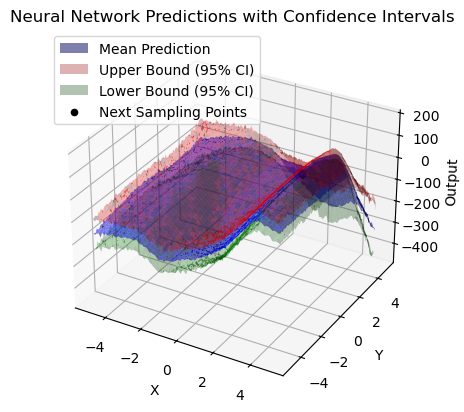

In [59]:
df = perform_iteration(df)